In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import xrft
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.ticker as ticker

from utils import *
from train_v1 import *
from loss import *
from UNET import *

from scipy.optimize import curve_fit
import warnings
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

In [3]:
base_path = "gs://leap-persistent/YueWang/SSH/data"

def open_zarr(path):
    return xr.open_zarr(path, consolidated=True)

zca = open_zarr(f"{base_path}/zca_eps3.zarr").compute()

In [4]:
base_path = "gs://leap-persistent/YueWang/SWOT/data"

def open_zarr(path):
    return xr.open_zarr(path, consolidated=True)

cycle006_passID070 = open_zarr(f"{base_path}/cycle006_passID070.zarr").compute()

In [13]:
cycle006_passID070

<xarray.Dataset> Size: 5MB
Dimensions:                 (i: 92, j: 995)
Coordinates:
  * i                       (i) float64 736B 0.0 1.5 3.0 ... 133.5 135.0 136.5
  * j                       (j) float64 8kB 0.0 1.5 3.0 ... 1.49e+03 1.491e+03
Data variables:
    interp_ssha_filtered    (j, i) float64 732kB 0.3257 0.3278 ... nan nan
    interp_ssha_unfiltered  (j, i) float64 732kB 0.3419 0.341 0.3401 ... nan nan
    latitude                (j, i) float64 732kB -36.86 -36.86 ... nan nan
    longitude               (j, i) float64 732kB 14.47 14.46 14.44 ... nan nan
    quality_flag            (j, i) float64 732kB 9.0 9.0 8.0 7.0 ... nan nan nan
    ssha_filtered           (j, i) float64 732kB nan nan nan nan ... nan nan nan
    ssha_unfiltered         (j, i) float64 732kB nan nan nan nan ... nan nan nan
Attributes: (12/44)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    time_coverage_end:               2023-11-05T01:20:28Z
    time_coverage_resolution:        PT0.3S
    time_coverage_start:             2023-11-05T00:29:02Z
    title:                           NRT SWOT KaRIn & nadir Global Ocean swat...

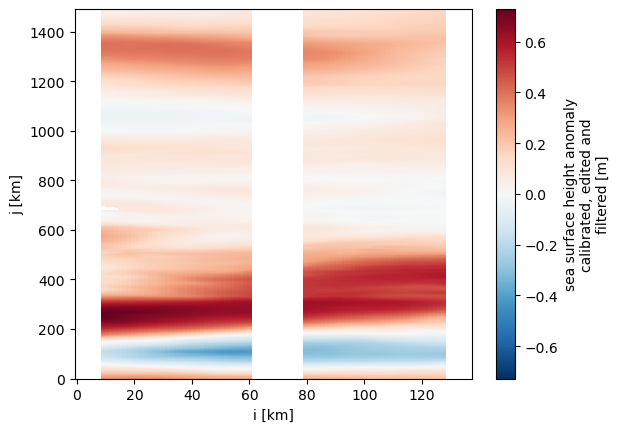

In [14]:
ssha_filtered = cycle006_passID070.ssha_filtered
ssha_filtered.plot()

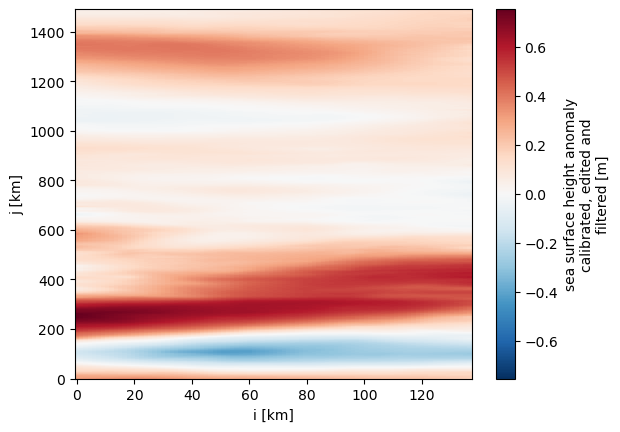

In [20]:
interp_ssha_filtered = cycle006_passID070.interp_ssha_filtered
interp_ssha_filtered.plot()

In [27]:
strong_ssh_sample = interp_ssha_filtered.isel(i=slice(12,66),j=slice(100,154)).values
weak_ssh_sample = interp_ssha_filtered.isel(i=slice(12,66),j=slice(600,654)).values
combined_sample = np.stack([strong_ssh_sample, weak_ssh_sample], axis=0)

# Get the dimensions from the original arrays
i_size, j_size = strong_ssh_sample.shape

# Create coordinate arrays
sample_coords = ['strong', 'weak']  # Sample names
i_coords = np.arange(12, 12 + i_size)  # Original i coordinates
j_coords_strong = np.arange(100, 100 + j_size)  # Original j coordinates for strong sample
j_coords_weak = np.arange(600, 600 + j_size)    # Original j coordinates for weak sample

# Note: Since we're combining regions with different j coordinates but want a single j dimension,
# we'll use relative j coordinates (0 to j_size-1) instead of the original absolute coordinates
j_coords = np.arange(j_size)

# Create the xarray DataArray
sample_da = xr.DataArray(
    data=combined_sample,
    dims=['sample', 'i', 'j'],
    coords={
        'sample': sample_coords,
        'i': i_coords,
        'j': j_coords
    },
    attrs={
        'description': 'Combined strong and weak SSH samples',
        'j_coords_strong': j_coords_strong,  # Store original j coordinates as attributes
        'j_coords_weak': j_coords_weak
    }
)

# Verify the DataArray
print(sample_da)

<xarray.DataArray (sample: 2, i: 54, j: 54)> Size: 47kB
array([[[-2.1000000e-03, -6.1500000e-03, -1.0650000e-02, ...,
         -2.1207500e-01, -2.1050000e-01, -2.0750000e-01],
        [ 9.0000000e-03,  4.8937500e-03,  3.0000000e-04, ...,
         -2.0592500e-01, -2.0457500e-01, -2.0185625e-01],
        [ 2.0550000e-02,  1.6275000e-02,  1.1475000e-02, ...,
         -1.9891250e-01, -1.9790000e-01, -1.9553750e-01],
        ...,
        [ 6.4907500e-01,  6.4271875e-01,  6.3621250e-01, ...,
          3.0841875e-01,  3.0187500e-01,  2.9827500e-01],
        [ 6.5470000e-01,  6.4862500e-01,  6.4225000e-01, ...,
          3.2040000e-01,  3.1380000e-01,  3.0907500e-01],
        [ 6.5912500e-01,  6.5338750e-01,  6.4716250e-01, ...,
          3.3202500e-01,  3.2520000e-01,  3.1985625e-01]],

       [[ 8.6700000e-02,  8.7750000e-02,  8.8950000e-02, ...,
          7.1450000e-02,  7.2500000e-02,  7.3250000e-02],
        [ 8.6550000e-02,  8.7150000e-02,  8.8087500e-02, ...,
          7.1037500e-02,  7

In [34]:
# import numpy as np
# import xarray as xr
# import matplotlib.pyplot as plt
# from numpy.random import default_rng


# # Extract the interpolated ssh filtered data
# da = cycle006_passID070.interp_ssha_filtered

# # 1. Replace NaN with 0
# print("Original data shape:", da.shape)
# print("NaN count before:", np.isnan(da.values).sum())

# # Replace NaN with 0
# da_filled = da.fillna(0)
# print("NaN count after:", np.isnan(da_filled.values).sum())

# # 2. Create random patches
# def random_crop_patches(data_array, patch_size=54, num_patches=40):
#     """
#     Randomly crop patches from a DataArray
    
#     Parameters:
#     -----------
#     data_array : xr.DataArray
#         Input data with dimensions (j, i)
#     patch_size : int
#         Size of square patches to extract
#     num_patches : int
#         Number of patches to extract
        
#     Returns:
#     --------
#     xr.DataArray
#         Array of patches with dimensions (sample, j, i)
#     """
#     j_size, i_size = data_array.shape
    
#     # Available range for top-left corner of patches
#     j_max = j_size - patch_size
#     i_max = i_size - patch_size
    
#     if j_max <= 0 or i_max <= 0:
#         raise ValueError(f"Patch size {patch_size} is too large for data shape {data_array.shape}")
    
#     # Initialize random number generator
#     rng = default_rng(seed=42)  # For reproducibility
    
#     # Generate random top-left corners for patches
#     j_starts = rng.integers(0, j_max, size=num_patches)
#     i_starts = rng.integers(0, i_max, size=num_patches)
    
#     # Create array to hold all patches
#     patches_data = np.zeros((num_patches, patch_size, patch_size))
    
#     # Extract each patch
#     for p in range(num_patches):
#         j_start = j_starts[p]
#         i_start = i_starts[p]
#         patch = data_array.isel(
#             j=slice(j_start, j_start + patch_size),
#             i=slice(i_start, i_start + patch_size)
#         ).values
#         patches_data[p] = patch
    
#     # Create new DataArray with patches
#     patches = xr.DataArray(
#         patches_data,
#         dims=["sample", "j", "i"],
#         coords={
#             "sample": np.arange(num_patches),
#             "j": np.arange(patch_size),
#             "i": np.arange(patch_size),
#             "patch_j_start": ("sample", j_starts),
#             "patch_i_start": ("sample", i_starts)
#         }
#     )
    
#     return patches

# # Create 40 patches of size 54x54
# patches = random_crop_patches(da_filled, patch_size=54, num_patches=40)
# print("\nPatches shape:", patches.shape)
# print("Patches dimensions:", patches.dims)
# print("Patches coordinates:", list(patches.coords))



Original data shape: (995, 92)
NaN count before: 92
NaN count after: 0

Patches shape: (40, 54, 54)
Patches dimensions: ('sample', 'j', 'i')
Patches coordinates: ['sample', 'j', 'i', 'patch_j_start', 'patch_i_start']


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

zca_Vt_ubm = torch.from_numpy(zca.zca_Vt_ubm.values).float().to(device)
zca_mean_ubm = torch.from_numpy(zca.zca_mean_ubm.values).float().to(device)
zca_scale_ubm = torch.from_numpy(zca.zca_scale_ubm.values).float().to(device)

batch_size = 8

x_test = torch.from_numpy(sample_da.values).float().unsqueeze(1).to(device)
y_test = torch.from_numpy(sample_da.values).float().unsqueeze(1).to(device)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def inverse_zca_transform_torch(data_zca, Vt, scale, data_mean):
    """
    Inverse ZCA transformation in PyTorch (GPU-compatible).
    """
    num_images, img_rows, img_cols = data_zca.shape
    D = img_rows * img_cols
    data_zca_flat = data_zca.view(num_images, D)
    
    # Handle NaNs by imputing with 0 (mean in original space)
    mask = ~torch.isnan(data_zca_flat)
    data_zca_flat_clean = torch.where(mask, data_zca_flat, torch.zeros_like(data_zca_flat))
    
    # Step 1: Project to PCA space
    transformed = torch.matmul(data_zca_flat_clean, Vt.T)
    # Step 2: Undo scaling
    rescaled = transformed / scale
    # Step 3: Project back to original space
    original_centered = torch.matmul(rescaled, Vt)
    data_reconstructed_flat = original_centered + data_mean
    
    # Restore NaNs and reshape
    data_reconstructed_flat[~mask] = torch.nan
    return data_reconstructed_flat.view(num_images, img_rows, img_cols)

def inverse_zca_variance_torch(var_zca, Vt, scale):
    """
    Propagate variance through inverse ZCA in PyTorch.
    """
    num_images, img_rows, img_cols = var_zca.shape
    D = img_rows * img_cols
    var_zca_flat = var_zca.view(num_images, D)
    
    # Step 1: Project variance through Vt.T
    var_step1 = torch.matmul(var_zca_flat, (Vt.T ** 2))
    # Step 2: Scale variance
    var_step2 = var_step1 / (scale ** 2)
    # Step 3: Project variance through Vt
    var_data_flat = torch.matmul(var_step2, (Vt ** 2))
    
    return var_data_flat.view(num_images, img_rows, img_cols)

def inverse_zca_transform_sigma_torch(sigma_zca, Vt, scale):
    """
    Propagate standard deviation through inverse ZCA in PyTorch.
    """
    var_zca = sigma_zca ** 2
    var_data = inverse_zca_variance_torch(var_zca, Vt, scale)
    return torch.sqrt(var_data)
    
def evaluate_model_zca(model, device, test_loader, Vt, scale, data_mean, ssh_test, checkpoint_path, probabilistic=False):
    model = model.to(device)
    model.eval()
    eps = 1e-6

    # Load checkpoint
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint at {checkpoint_path}")

    # Convert ZCA params to PyTorch tensors on the same device
    Vt_tensor = torch.from_numpy(Vt).float().to(device)
    scale_tensor = torch.from_numpy(scale).float().to(device)
    data_mean_tensor = torch.from_numpy(data_mean).float().to(device)

    # Collect predictions
    mu_zca_list, sigma_zca_list = [], []
    
    with torch.no_grad():
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            
            if probabilistic:
                mu = outputs[:, 0, ...]
                log_sigma = outputs[:, 1, ...]
                sigma = torch.exp(log_sigma).clamp(min=eps)
                mu_zca_list.append(mu)
                sigma_zca_list.append(sigma)
            else:
                mu_zca_list.append(outputs)

    # Process outputs
    mu_zca = torch.cat(mu_zca_list, dim=0)
    if probabilistic:
        sigma_zca = torch.cat(sigma_zca_list, dim=0)
        # Propagate uncertainty on GPU
        sigma_ubm = inverse_zca_transform_sigma_torch(sigma_zca, Vt_tensor, scale_tensor)
        sigma_ubm_np = sigma_ubm.cpu().numpy()
        sigma_zca_np = sigma_zca.cpu().numpy()
    else:
        sigma_zca = None
        sigma_ubm_np = None

    # Invert ZCA for mean prediction
    ubm_prediction = inverse_zca_transform_torch(mu_zca, Vt_tensor, scale_tensor, data_mean_tensor)
    ubm_prediction_np = ubm_prediction.cpu().numpy()
    
    # Convert to xarray DataArrays (assuming `xr_da` handles numpy inputs)
    mu_zca_da = xr_da(mu_zca.cpu().numpy(), ssh_test)
    sigma_zca_da = xr_da(sigma_zca_np, ssh_test) if probabilistic else None
    sigma_ubm_da = xr_da(sigma_ubm_np, ssh_test) if probabilistic else None
    ubm_da = xr_da(ubm_prediction_np, ssh_test)
    bm_da = ssh_test - ubm_da

    return mu_zca_da, sigma_zca_da, sigma_ubm_da, ubm_da, bm_da

mu_zca, sigma_zca, ubm_sigma_zca, ubm_mu_zca, bm_mu_zca = evaluate_model_zca(
    UNet(in_channels=1, out_channels=2, initial_features=32, depth=4), device, test_loader,
    zca.zca_Vt_ubm.values, zca.zca_scale_ubm.values, zca.zca_mean_ubm.values,
    sample_da,
    '/home/jovyan/GRL/checkpoint/eps9.pth',
    probabilistic=True
)



def evaluate_model(model, device, test_loader, ssh_test, checkpoint_path):
    model = model.to(device)
    model.eval()

    # Load checkpoint
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint at {checkpoint_path}")

    # Collect predictions
    predictions_list = []
    
    with torch.no_grad():
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions_list.append(outputs)

    # Process outputs
    predictions = torch.cat(predictions_list, dim=0)
    predictions_np = predictions.squeeze(1).cpu().numpy()
    
    # Convert to xarray DataArrays (assuming `xr_da` handles numpy inputs)
    ubm_da = xr_da(predictions_np, ssh_test)
    bm_da = ssh_test - ubm_da

    return ubm_da, bm_da


/tmp/ipykernel_2461/561366500.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from /home/jovyan/GRL/checkpoint/eps9.pth


In [31]:
ssh_sample = sample_da.isel(sample=1).values
ubm_sample = ubm_mu_zca.isel(sample=1).values
bm_sample = ssh_sample - ubm_sample

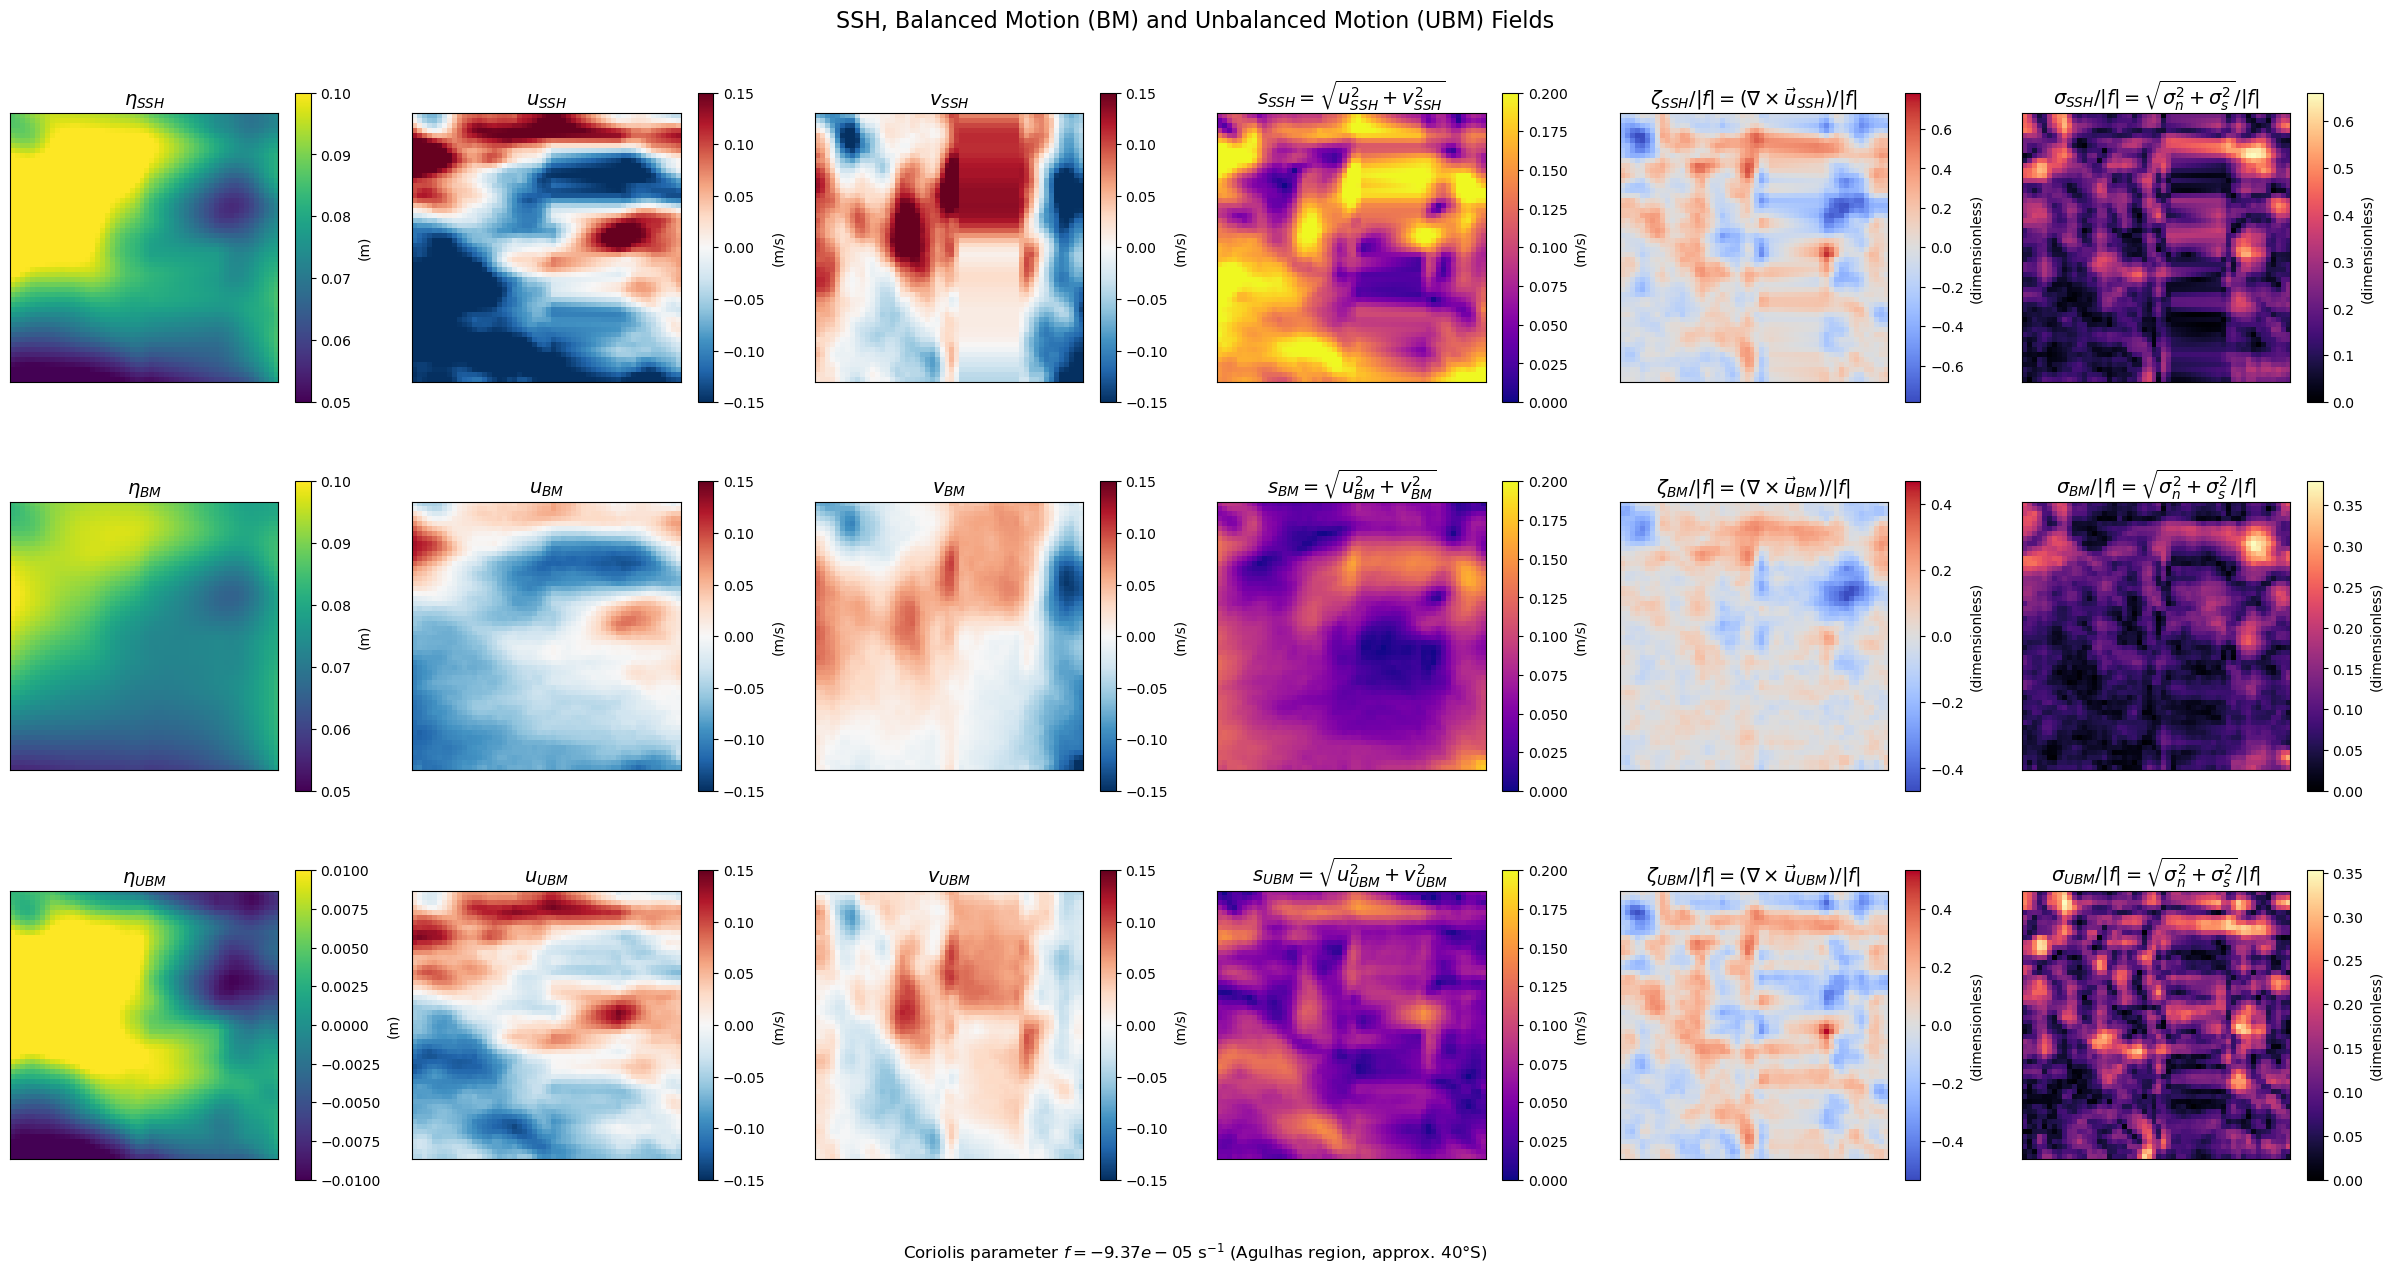

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm


# Define Coriolis parameter for Algulhas region (approximately 40°S)
f = -9.37e-5  # s^-1 (negative in Southern Hemisphere)
g = 9.81  # gravitational acceleration (m/s^2)

# Calculate SSH velocities (if not already calculated)
def calculate_geostrophic_velocities(eta, f, g, dx, dy):
    """Calculate geostrophic velocities from SSH."""
    # Calculate gradients
    deta_dx = np.zeros_like(eta)
    deta_dy = np.zeros_like(eta)
    
    # x-gradient (central differences)
    deta_dx[:, 1:-1] = (eta[:, 2:] - eta[:, :-2]) / (2 * dx)
    # y-gradient (central differences)
    deta_dy[1:-1, :] = (eta[2:, :] - eta[:-2, :]) / (2 * dy)
    
    # Handle boundaries
    deta_dx[:, 0] = (eta[:, 1] - eta[:, 0]) / dx
    deta_dx[:, -1] = (eta[:, -1] - eta[:, -2]) / dx
    deta_dy[0, :] = (eta[1, :] - eta[0, :]) / dy
    deta_dy[-1, :] = (eta[-1, :] - eta[-2, :]) / dy
    
    # Calculate velocities
    u = -(g/f) * deta_dy
    v = (g/f) * deta_dx
    
    return u, v

def calculate_flow_properties(u, v, dx, dy):
    """Calculate vorticity and strain from velocity components."""
    # Calculate derivatives
    du_dx = np.zeros_like(u)
    du_dy = np.zeros_like(u)
    dv_dx = np.zeros_like(v)
    dv_dy = np.zeros_like(v)
    
    # Interior points using central differences
    du_dx[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2 * dx)
    du_dy[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2 * dy)
    dv_dx[:, 1:-1] = (v[:, 2:] - v[:, :-2]) / (2 * dx)
    dv_dy[1:-1, :] = (v[2:, :] - v[:-2, :]) / (2 * dy)
    
    # Handle boundaries
    du_dx[:, 0] = (u[:, 1] - u[:, 0]) / dx
    du_dx[:, -1] = (u[:, -1] - u[:, -2]) / dx
    du_dy[0, :] = (u[1, :] - u[0, :]) / dy
    du_dy[-1, :] = (u[-1, :] - u[-2, :]) / dy
    dv_dx[:, 0] = (v[:, 1] - v[:, 0]) / dx
    dv_dx[:, -1] = (v[:, -1] - v[:, -2]) / dx
    dv_dy[0, :] = (v[1, :] - v[0, :]) / dy
    dv_dy[-1, :] = (v[-1, :] - v[-2, :]) / dy
    
    # Vorticity
    vorticity = dv_dx - du_dy
    
    # Strain components
    strain_normal = du_dx - dv_dy
    strain_shear = dv_dx + du_dy
    
    # Total strain magnitude
    strain = np.sqrt(strain_normal**2 + strain_shear**2)
    
    return vorticity, strain

# Define grid spacing
dx = 1500  # meters
dy = 1500  # meters

# Calculate for SSH
u_ssh, v_ssh = calculate_geostrophic_velocities(ssh_sample, f, g, dx, dy)
speed_ssh = np.sqrt(u_ssh**2 + v_ssh**2)
vort_ssh, strain_ssh = calculate_flow_properties(u_ssh, v_ssh, dx, dy)

# Calculate for BM
u_bm, v_bm = calculate_geostrophic_velocities(bm_sample, f, g, dx, dy)
speed_bm = np.sqrt(u_bm**2 + v_bm**2)
vort_bm, strain_bm = calculate_flow_properties(u_bm, v_bm, dx, dy)


# Calculate for UBM
u_ubm, v_ubm = calculate_geostrophic_velocities(ubm_sample, f, g, dx, dy)
speed_ubm = np.sqrt(u_ubm**2 + v_ubm**2)
vort_ubm, strain_ubm = calculate_flow_properties(u_ubm, v_ubm, dx, dy)

# Normalize vorticity and strain by f
vort_ssh_normalized = vort_ssh / abs(f)
strain_ssh_normalized = strain_ssh / abs(f)
vort_bm_normalized = vort_bm / abs(f)
strain_bm_normalized = strain_bm / abs(f)
vort_ubm_normalized = vort_ubm / abs(f)
strain_ubm_normalized = strain_ubm / abs(f)

# Create a figure with 3x6 subplots
fig, axes = plt.subplots(3, 6, figsize=(24, 12))

# Define custom colormaps for each variable type
scalar_cmap = 'viridis'        # For SSH, BM and UBM
velocity_cmap = 'RdBu_r'       # For velocity components
speed_cmap = 'plasma'          # For speed
vorticity_cmap = 'coolwarm'    # For vorticity
strain_cmap = 'magma'          # For strain magnitude

# Row 0: SSH fields
# SSH
im00 = axes[0, 0].imshow(ssh_sample, cmap=scalar_cmap, vmin=0.05, vmax=0.1)
axes[0, 0].set_title(r'$\eta_{SSH}$', fontsize=14)
fig.colorbar(im00, ax=axes[0, 0], shrink=0.8, label='(m)')

# u_ssh
u_ssh_max = max(abs(u_ssh.min()), abs(u_ssh.max()))
im01 = axes[0, 1].imshow(u_ssh, cmap=velocity_cmap, vmin=-0.15, vmax=0.15)
axes[0, 1].set_title(r'$u_{SSH}$', fontsize=14)
fig.colorbar(im01, ax=axes[0, 1], shrink=0.8, label='(m/s)')

# v_ssh
v_ssh_max = max(abs(v_ssh.min()), abs(v_ssh.max()))
im02 = axes[0, 2].imshow(v_ssh, cmap=velocity_cmap, vmin=-0.15, vmax=0.15)
axes[0, 2].set_title(r'$v_{SSH}$', fontsize=14)
fig.colorbar(im02, ax=axes[0, 2], shrink=0.8, label='(m/s)')

# speed_ssh
im03 = axes[0, 3].imshow(speed_ssh, cmap=speed_cmap, vmin=0, vmax=0.2)
axes[0, 3].set_title(r'$s_{SSH} = \sqrt{u_{SSH}^2 + v_{SSH}^2}$', fontsize=14)
fig.colorbar(im03, ax=axes[0, 3], shrink=0.8, label='(m/s)')

# vorticity_ssh (normalized)
vort_ssh_norm_max = max(abs(vort_ssh_normalized.min()), abs(vort_ssh_normalized.max()))
im04 = axes[0, 4].imshow(vort_ssh_normalized, cmap=vorticity_cmap, vmin=-vort_ssh_norm_max, vmax=vort_ssh_norm_max)
axes[0, 4].set_title(r'$\zeta_{SSH}/|f| = (\nabla \times \vec{u}_{SSH})/|f|$', fontsize=14)
fig.colorbar(im04, ax=axes[0, 4], shrink=0.8, label='(dimensionless)')

# strain_ssh (normalized)
strain_ssh_norm_max = max(abs(strain_ssh_normalized.min()), abs(strain_ssh_normalized.max()))
im05 = axes[0, 5].imshow(strain_ssh_normalized, cmap=strain_cmap, vmin=0, vmax=strain_ssh_norm_max)
axes[0, 5].set_title(r'$\sigma_{SSH}/|f| = \sqrt{\sigma_n^2 + \sigma_s^2}/|f|$', fontsize=14)
fig.colorbar(im05, ax=axes[0, 5], shrink=0.8, label='(dimensionless)')

# Row 1: BM fields
# BM
im10 = axes[1, 0].imshow(bm_sample, cmap=scalar_cmap, vmin=0.05, vmax=0.1)
axes[1, 0].set_title(r'$\eta_{BM}$', fontsize=14)
fig.colorbar(im10, ax=axes[1, 0], shrink=0.8, label='(m)')

# u_bm
u_bm_max = max(abs(u_bm.min()), abs(u_bm.max()))
im11 = axes[1, 1].imshow(u_bm, cmap=velocity_cmap, vmin=-0.15, vmax=0.15)
axes[1, 1].set_title(r'$u_{BM}$', fontsize=14)
fig.colorbar(im11, ax=axes[1, 1], shrink=0.8, label='(m/s)')

# v_bm
v_bm_max = max(abs(v_bm.min()), abs(v_bm.max()))
im12 = axes[1, 2].imshow(v_bm, cmap=velocity_cmap, vmin=-0.15, vmax=0.15)
axes[1, 2].set_title(r'$v_{BM}$', fontsize=14)
fig.colorbar(im12, ax=axes[1, 2], shrink=0.8, label='(m/s)')

# speed_bm
im13 = axes[1, 3].imshow(speed_bm, cmap=speed_cmap, vmin=0, vmax=0.2)
axes[1, 3].set_title(r'$s_{BM} = \sqrt{u_{BM}^2 + v_{BM}^2}$', fontsize=14)
fig.colorbar(im13, ax=axes[1, 3], shrink=0.8, label='(m/s)')

# vorticity_bm (normalized)
vort_bm_norm_max = max(abs(vort_bm_normalized.min()), abs(vort_bm_normalized.max()))
im14 = axes[1, 4].imshow(vort_bm_normalized, cmap=vorticity_cmap, vmin=-vort_bm_norm_max, vmax=vort_bm_norm_max)
axes[1, 4].set_title(r'$\zeta_{BM}/|f| = (\nabla \times \vec{u}_{BM})/|f|$', fontsize=14)
fig.colorbar(im14, ax=axes[1, 4], shrink=0.8, label='(dimensionless)')

# strain_bm (normalized)
strain_bm_norm_max = max(abs(strain_bm_normalized.min()), abs(strain_bm_normalized.max()))
im15 = axes[1, 5].imshow(strain_bm_normalized, cmap=strain_cmap, vmin=0, vmax=strain_bm_norm_max)
axes[1, 5].set_title(r'$\sigma_{BM}/|f| = \sqrt{\sigma_n^2 + \sigma_s^2}/|f|$', fontsize=14)
fig.colorbar(im15, ax=axes[1, 5], shrink=0.8, label='(dimensionless)')

# Row 2: UBM fields
# UBM
im20 = axes[2, 0].imshow(ubm_sample, cmap=scalar_cmap, vmin=-0.01, vmax=0.01)
axes[2, 0].set_title(r'$\eta_{UBM}$', fontsize=14)
fig.colorbar(im20, ax=axes[2, 0], shrink=0.8, label='(m)')

# u_ubm
u_ubm_max = max(abs(u_ubm.min()), abs(u_ubm.max()))
im21 = axes[2, 1].imshow(u_ubm, cmap=velocity_cmap, vmin=-0.15, vmax=0.15)
axes[2, 1].set_title(r'$u_{UBM}$', fontsize=14)
fig.colorbar(im21, ax=axes[2, 1], shrink=0.8, label='(m/s)')

# v_ubm
v_ubm_max = max(abs(v_ubm.min()), abs(v_ubm.max()))
im22 = axes[2, 2].imshow(v_ubm, cmap=velocity_cmap, vmin=-0.15, vmax=0.15)
axes[2, 2].set_title(r'$v_{UBM}$', fontsize=14)
fig.colorbar(im22, ax=axes[2, 2], shrink=0.8, label='(m/s)')

# speed_ubm
im23 = axes[2, 3].imshow(speed_ubm, cmap=speed_cmap, vmin=0, vmax=0.2)
axes[2, 3].set_title(r'$s_{UBM} = \sqrt{u_{UBM}^2 + v_{UBM}^2}$', fontsize=14)
fig.colorbar(im23, ax=axes[2, 3], shrink=0.8, label='(m/s)')

# vorticity_ubm (normalized)
vort_ubm_norm_max = max(abs(vort_ubm_normalized.min()), abs(vort_ubm_normalized.max()))
im24 = axes[2, 4].imshow(vort_ubm_normalized, cmap=vorticity_cmap, vmin=-vort_ubm_norm_max, vmax=vort_ubm_norm_max)
axes[2, 4].set_title(r'$\zeta_{UBM}/|f| = (\nabla \times \vec{u}_{UBM})/|f|$', fontsize=14)
fig.colorbar(im24, ax=axes[2, 4], shrink=0.8, label='(dimensionless)')

# strain_ubm (normalized)
strain_ubm_norm_max = max(abs(strain_ubm_normalized.min()), abs(strain_ubm_normalized.max()))
im25 = axes[2, 5].imshow(strain_ubm_normalized, cmap=strain_cmap, vmin=0, vmax=strain_ubm_norm_max)
axes[2, 5].set_title(r'$\sigma_{UBM}/|f| = \sqrt{\sigma_n^2 + \sigma_s^2}/|f|$', fontsize=14)
fig.colorbar(im25, ax=axes[2, 5], shrink=0.8, label='(dimensionless)')

# Turn off axis ticks for all subplots
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Fix layout to prevent overlap
plt.tight_layout()

# Add a title to the whole figure
plt.suptitle('SSH, Balanced Motion (BM) and Unbalanced Motion (UBM) Fields', 
             fontsize=16, y=1.02)

# Add text with Coriolis parameter value
plt.figtext(0.5, -0.02, f'Coriolis parameter $f = {f:.2e}$ s$^{{-1}}$ (Agulhas region, approx. 40°S)', 
            ha='center', fontsize=12)

# Save figure with high resolution
plt.savefig('ocean_dynamics_complete_analysis.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

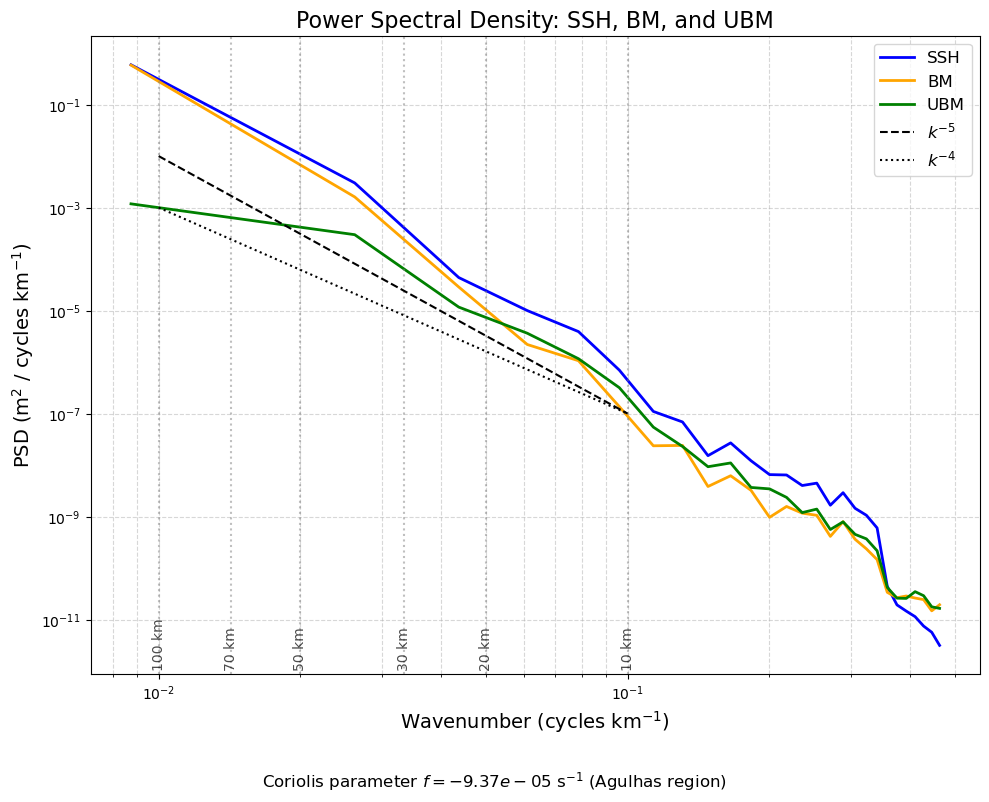

In [47]:
import matplotlib.pyplot as plt
import numpy as np


# Define a function to calculate the PSD if it's not already defined
def calculate_psd_km(field, dx_km=1.5):
    """
    Calculate the 2D Power Spectral Density and convert to 1D radial average.
    
    Parameters:
    -----------
    field : 2D numpy array
        The input field (e.g., SSH, BM, UBM)
    dx_km : float
        Grid spacing in kilometers
        
    Returns:
    --------
    psd_1d : numpy array
        1D radially averaged power spectrum
    freq_r : numpy array
        Corresponding radial frequencies in cycles/km
    """
    # Get dimensions
    ny, nx = field.shape
    
    # Apply Hann window to reduce edge effects
    window = np.outer(np.hanning(ny), np.hanning(nx))
    field_windowed = field * window
    
    # Compute 2D FFT and shift zero frequency to center
    fft2 = np.fft.fft2(field_windowed)
    fft2_shifted = np.fft.fftshift(fft2)
    
    # Calculate the Power Spectral Density
    psd2d = np.abs(fft2_shifted)**2
    
    # Normalize by number of points and grid spacing
    psd2d = psd2d / (nx * ny) * (dx_km**2)
    
    # Create frequency grids
    freq_x = np.fft.fftshift(np.fft.fftfreq(nx, d=dx_km))
    freq_y = np.fft.fftshift(np.fft.fftfreq(ny, d=dx_km))
    
    # Create meshgrid for radial binning
    kx, ky = np.meshgrid(freq_x, freq_y)
    k_rad = np.sqrt(kx**2 + ky**2)
    
    # Create radial bins
    max_freq = np.max(k_rad)
    n_bins = min(nx, ny) // 2
    freq_bins = np.linspace(0, max_freq, n_bins+1)
    
    # Calculate bin centers
    freq_r = (freq_bins[1:] + freq_bins[:-1]) / 2
    
    # Initialize output array
    psd_1d = np.zeros(n_bins)
    
    # Radial binning
    for i in range(n_bins):
        bin_mask = (k_rad >= freq_bins[i]) & (k_rad < freq_bins[i+1])
        if np.any(bin_mask):
            psd_1d[i] = np.mean(psd2d[bin_mask])
    
    return psd_1d, freq_r

# Create the figure
plt.figure(figsize=(10, 8))

# Extract fields for this sample
ssh = ssh_sample  # Use the variable you already defined
bm = bm_sample    # Use the variable you already defined
ubm = ubm_sample  # Use the variable you already defined

# Calculate PSDs
psd_ssh, freq_r_ssh = calculate_psd_km(ssh)
psd_bm, freq_r_bm = calculate_psd_km(bm)
psd_ubm, freq_r_ubm = calculate_psd_km(ubm)

# Plot on log-log scale
plt.loglog(freq_r_ssh, psd_ssh, label='SSH', linewidth=2, color='blue')
plt.loglog(freq_r_bm, psd_bm, label='BM', linewidth=2, color='orange')
plt.loglog(freq_r_ubm, psd_ubm, label='UBM', linewidth=2, color='green')

# Add reference wavelengths
wavelengths = [100, 70, 50, 30, 20, 10]  # in km
for wl in wavelengths:
    freq = 1.0 / wl
    plt.axvline(x=freq, linestyle=':', color='gray', alpha=0.5)
    plt.text(freq, plt.ylim()[0]*1.2, f'{wl} km', 
            rotation=90, va='bottom', ha='center', fontsize=10, alpha=0.7)

# Add reference slopes for spectral cascades
# For k^-5 (Surface QG turbulence)
k_ref = np.array([0.01, 0.1])
E_ref_k5 = 1e-2 * (k_ref/k_ref[0])**(-5)
plt.loglog(k_ref, E_ref_k5, 'k--', linewidth=1.5, label=r'$k^{-5}$')

# For k^-4 (Frontogenesis)
E_ref_k4 = 1e-3 * (k_ref/k_ref[0])**(-4)
plt.loglog(k_ref, E_ref_k4, 'k:', linewidth=1.5, label=r'$k^{-4}$')

# Set axis labels and title
plt.xlabel(r'Wavenumber (cycles km$^{-1}$)', fontsize=14)
plt.ylabel(r'PSD (m$^{2}$ / cycles km$^{-1}$)', fontsize=14)
plt.title('Power Spectral Density: SSH, BM, and UBM', fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(frameon=True, fontsize=12, loc='best')

# Add annotation about the Coriolis parameter
plt.figtext(0.5, 0.01, f'Coriolis parameter $f = {f:.2e}$ s$^{{-1}}$ (Agulhas region)', 
            ha='center', fontsize=12)

# Adjust spacing and save
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('PSD_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The 

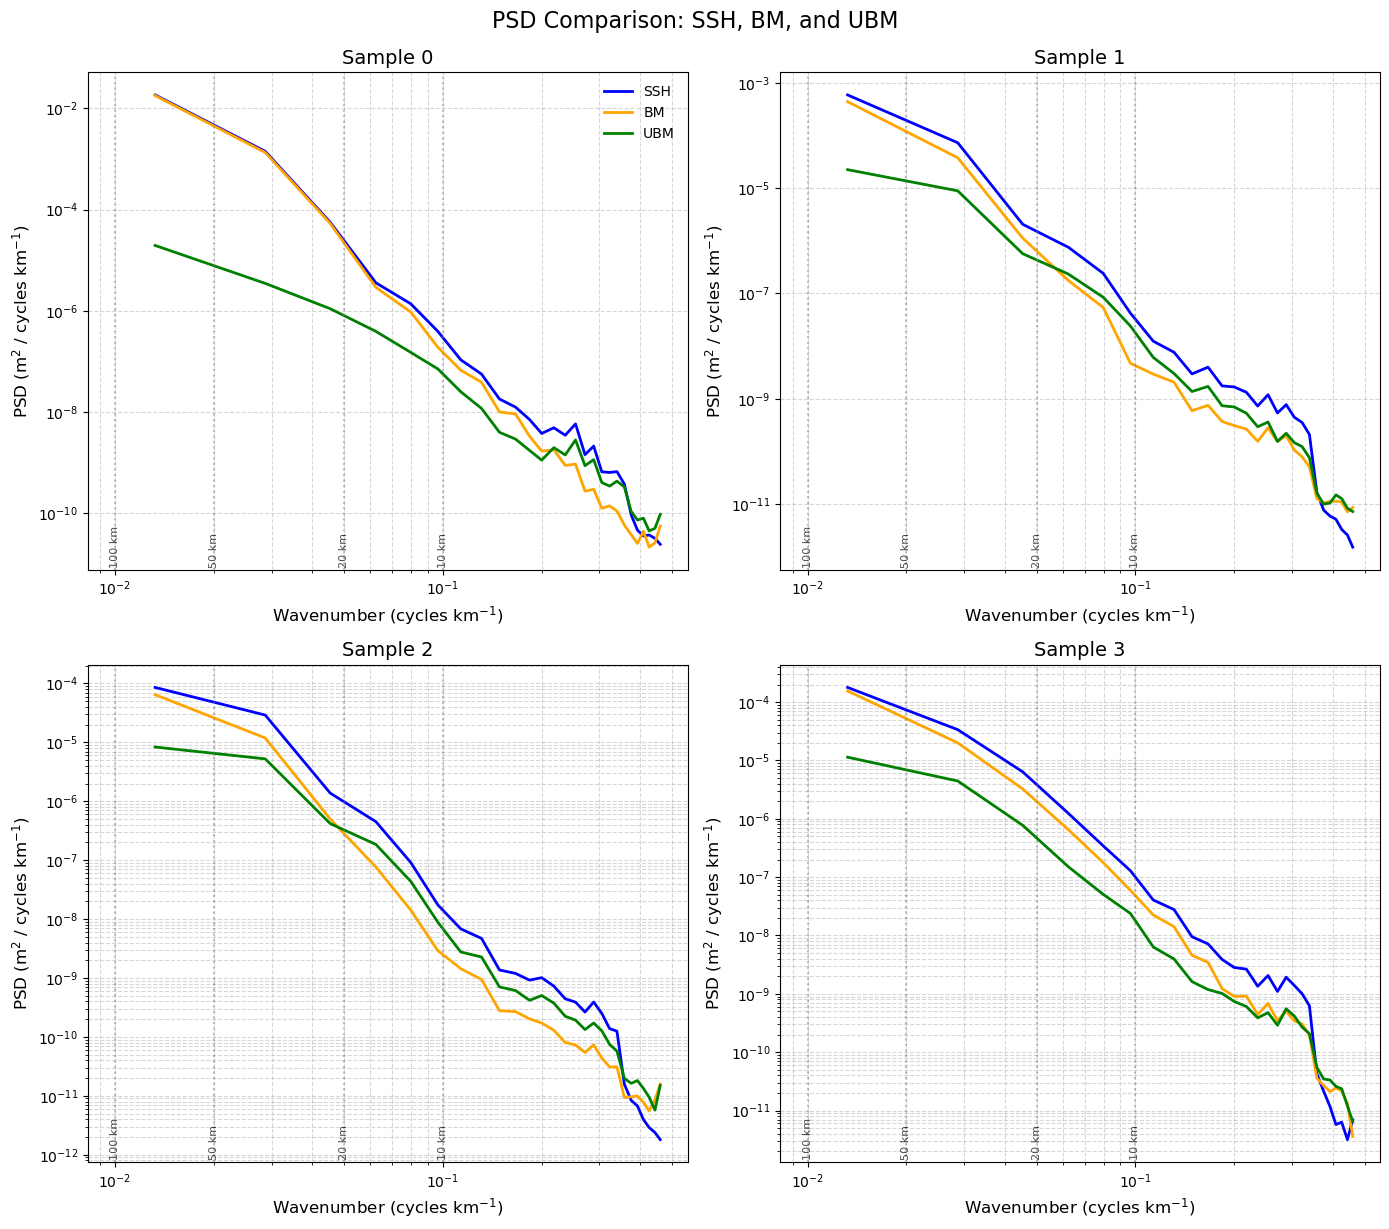

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to display
n_samples = 4

# We'll use the first 4 samples - modify if needed to use specific samples
sample_indices = [0, 1, 2, 3]  # Can be replaced with specific indices if desired

# Grid spacing in kilometers
dx_km = 1.5

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten for easier indexing

# Loop through selected samples
for i, sample_idx in enumerate(sample_indices):
    # Extract fields for this sample
    ssh = patches.isel(sample=sample_idx).values
    bm = bm_mu_zca.isel(sample=sample_idx).values
    ubm = ubm_mu_zca.isel(sample=sample_idx).values
    
    # Calculate PSDs
    psd_ssh = calculate_psd_km(ssh)
    psd_bm = calculate_psd_km(bm)
    psd_ubm = calculate_psd_km(ubm)
    
    # Plot on log-log scale
    axes[i].loglog(psd_ssh.freq_r, psd_ssh, label='SSH', linewidth=2, color='blue')
    axes[i].loglog(psd_bm.freq_r, psd_bm, label='BM', linewidth=2, color='orange')
    axes[i].loglog(psd_ubm.freq_r, psd_ubm, label='UBM', linewidth=2, color='green')
    
    # Add reference wavelengths
    wavelengths = [100, 50, 20, 10]  # in km
    for wl in wavelengths:
        freq = 1.0 / wl
        axes[i].axvline(x=freq, linestyle=':', color='gray', alpha=0.5)
        axes[i].text(freq, axes[i].get_ylim()[0]*1.1, f'{wl} km', 
                rotation=90, va='bottom', ha='center', fontsize=8, alpha=0.7)
    
    # Set axis labels and title
    axes[i].set_xlabel(r'Wavenumber (cycles km$^{-1}$)', fontsize=12)
    axes[i].set_ylabel(r'PSD (m$^{2}$ / cycles km$^{-1}$)', fontsize=12)
    axes[i].set_title(f'Sample {sample_idx}', fontsize=14)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.5)
    
    # Only add legend to the first subplot to avoid clutter
    if i == 0:
        axes[i].legend(frameon=False, fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()
plt.suptitle('PSD Comparison: SSH, BM, and UBM', fontsize=16, y=1.02)
plt.savefig('PSDs.png', dpi=300)
plt.show()